In [18]:
import numpy as np
from scipy import fft, optimize
import NAFFlib as naf
import statistics as st
import matplotlib.pyplot as plt
import time
from IPython.display import display, Math
import re
import csv

np.random.seed(0)

In [2]:
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 168])
Pos_ybpms = np.zeros([1024, 167])
S_xbpms = np.zeros([1024, 168])
S_ybpms = np.zeros([1024, 167])
with open('data_Wed_Jun_28_20-13-14_2023') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%168
            
            if (i - init_i)%168 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 171423:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%167
            
            if (i - init_i)%167 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [3]:
# Positions
# sddsconvert -ascii [file.sdds] [filename]
# /operations/app_store/Ramps/MADX/Au23-100GeV-e0/Blue/twiss.out
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1024-init_turn)
N_BPMy, _ = np.shape(BPMy) #(167, 1024-init_turn)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of Horizontal BPM = 0.08086005371776343


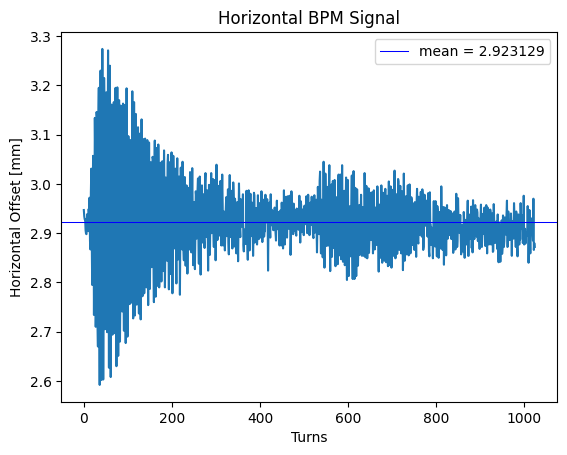

Standard deviation of Vertical BPM = 0.14039846131415454


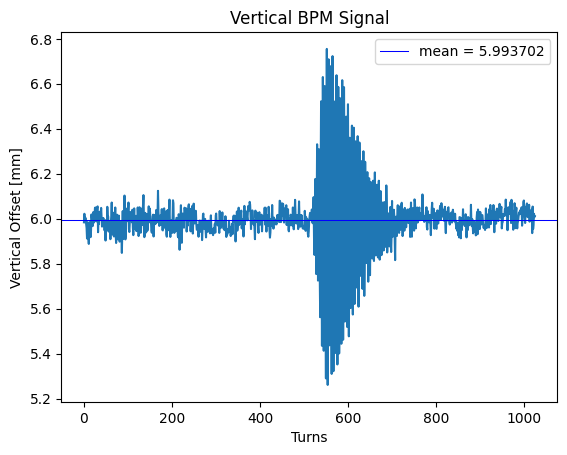

In [4]:
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal BPM Signal")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical BPM Signal")
plt.legend()
plt.show()

0.23483365949119372


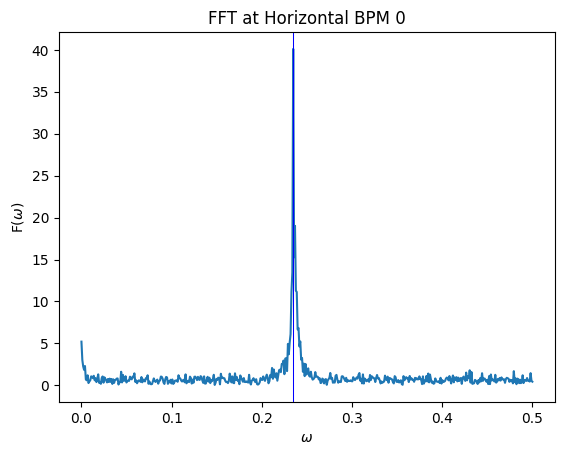

0.22896281800391388


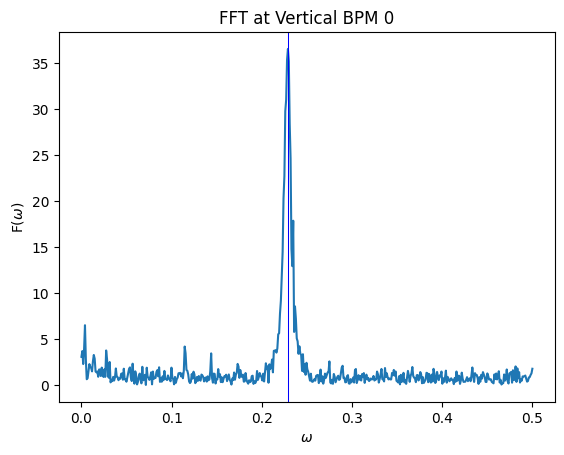

In [5]:
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
print(BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at Horizontal BPM 0")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
print(BPMy0_Tune_scipy)
plt.plot(Omega, BPMY0)
plt.axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
plt.title("FFT at Vertical BPM 0")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

0.00016808850880467574 0.0010185889772997558


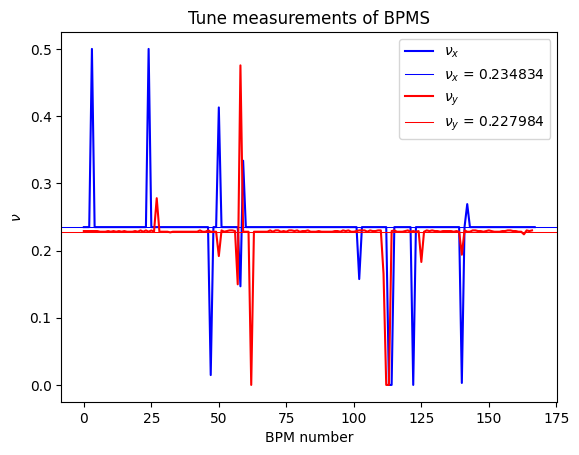

In [6]:
# Scipy to figure out tune
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from experiment
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)
print(delta_nu_x, delta_nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [7]:
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .01:
            Bad_BPM.append(i)
    return Bad_BPM

Bad_BPMx = Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx)
Bad_BPMy = Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy)
print(Bad_BPMx)
print(Bad_BPMy)

[3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
[27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


In [124]:
def model(x0, x0p, xc, beta, alpha, tunex, eps_sr, eps_nl, xisige, nvs, phis, Nturn=N_turns):
    
    turns = np.arange(Nturn)
    phi = 2*np.pi*tunex
    
    cs = np.cos(turns*phi)
    sn = np.sin(turns*phi)
    m11 = cs + alpha*sn
    m12 = beta*sn
    
    alpha = 2*xisige*np.sin(np.pi*nvs*turns + phis)/nvs
    alpha02 = (2*xisige*np.sin(phis)/nvs)**2
    decay = np.exp(-(alpha**2 - alpha02)/2 - (eps_nl*turns)**2 - eps_sr*turns)
    return (m11*(x0 - xc) + m12*x0p)*decay + xc

def log_likelihood(theta, sigma, data):
    
    predicted_data = model(*theta, len(data)) 
    diff = predicted_data-data
    ss = sigma[0]*sigma[0]+sigma[1]*sigma[1]*data*data
    
    return -np.sum(diff*diff/2.0/ss) - np.sum(np.log(np.sqrt(ss)))#*len(diff)


def metropolis_hastings(lf, data, iters, pinitials, p_step,
                        sinitials=[1e-4,1e-4], s_step=[1e-4,1e-4]):
    psamples = np.zeros((iters, len(pinitials)))
    ssamples = np.zeros((iters, 2))
    p = np.array(pinitials)
    s = np.array(sinitials)
    pstep = np.array(p_step)
    sstep = np.array(s_step)
    changed = False
    old_lh = lf(p,s, data)
    i = 0
    while i<iters:
        p_n = p + np.random.normal(size=len(pinitials))*pstep
        s_n = s + np.random.normal(size=len(sinitials))*sstep
        if p_n[6] < 0: # SR_eps  > 0
            continue
        if p_n[7] < 0: # nl_eps  > 0
            continue
        if p_n[8] < 0: # xi*sige > 0
            continue
        if p_n[9] <= 0: # nuz > 0
            continue
        if p_n[10] > np.pi:
            p_n[10] -= 2*np.pi
        if p_n[10] < -np.pi: 
            p_n[10] += 2*np.pi
        if s_n[0] < 0: # error rms size >0
            continue
        if s_n[1] < 0: # error rms size >0
            continue
        if changed:
            #old_lh=lf(p,s, data)
            old_lh = new_lh
            
        new_lh = lf(p_n,s_n, data)#-((p_n[0]-data[0])*(p_n[0]-data[0])/2/s_n/s_n+np.log(s_n))#*len(data)
        if np.log(np.random.rand()+1.0e-10) < new_lh - old_lh:
            p,s = p_n,s_n
            changed = True
        else:
            changed = False
        psamples[i] = p
        ssamples[i] = s
        i += 1
    return psamples, ssamples

In [15]:
#pinitials = [BPMx0[0], 0.0, BPMx0_mean, 1.0, 0, BPMx0_Tune_scipy, 0.0,  0.0, 0e-1, 8e-3, 0.1]
#p_step = [1e-3, 1e-3, 1e-3,  0,  0, 5e-7, 1e-6, 1e-6, 0e-3, 1e-4, 3e-3]
pinitials = [BPMx0[0], 0.0, BPMx0_mean, 1.0, 0, BPMx0_Tune_scipy, 0.0,  0.0, 0, 1e-2, 0.5]
p_step = [1e-3, 1e-3, 1e-3,  0,  0, 5e-7, 0, 0, 0, 0, 0]
sinitials = [1e-2, 0e-2]
s_step = [2e-4, 0e-3]
initial = 35

pinitials[6] = 0.0018
pinitials[7] = 0.0006
pinitials[8] = 0.00073
pinitials[9] = 1e-2
pinitials[10] = 1
p_step[6] = 1e-5
p_step[7] = 1e-5
p_step[8] = 1e-4
p_step[9] = 1e-4
p_step[10] = 3e-2

N_iter = 150000
begin = time.time()
# parr : iters x 11; sarr = iters x 2
parr, sarr = metropolis_hastings(log_likelihood, BPMx0[initial: N_turns//2 + initial], N_iter, 
                              pinitials, p_step, sinitials, s_step)
end = time.time()
print("Time elapsed for full model:", end - begin)

Time elapsed for full model: 97.07612299919128


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_41120/1588427351.py:30: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  Ax[i][j*2 + 1].set_ylim([np.min(target), np.max(target)])


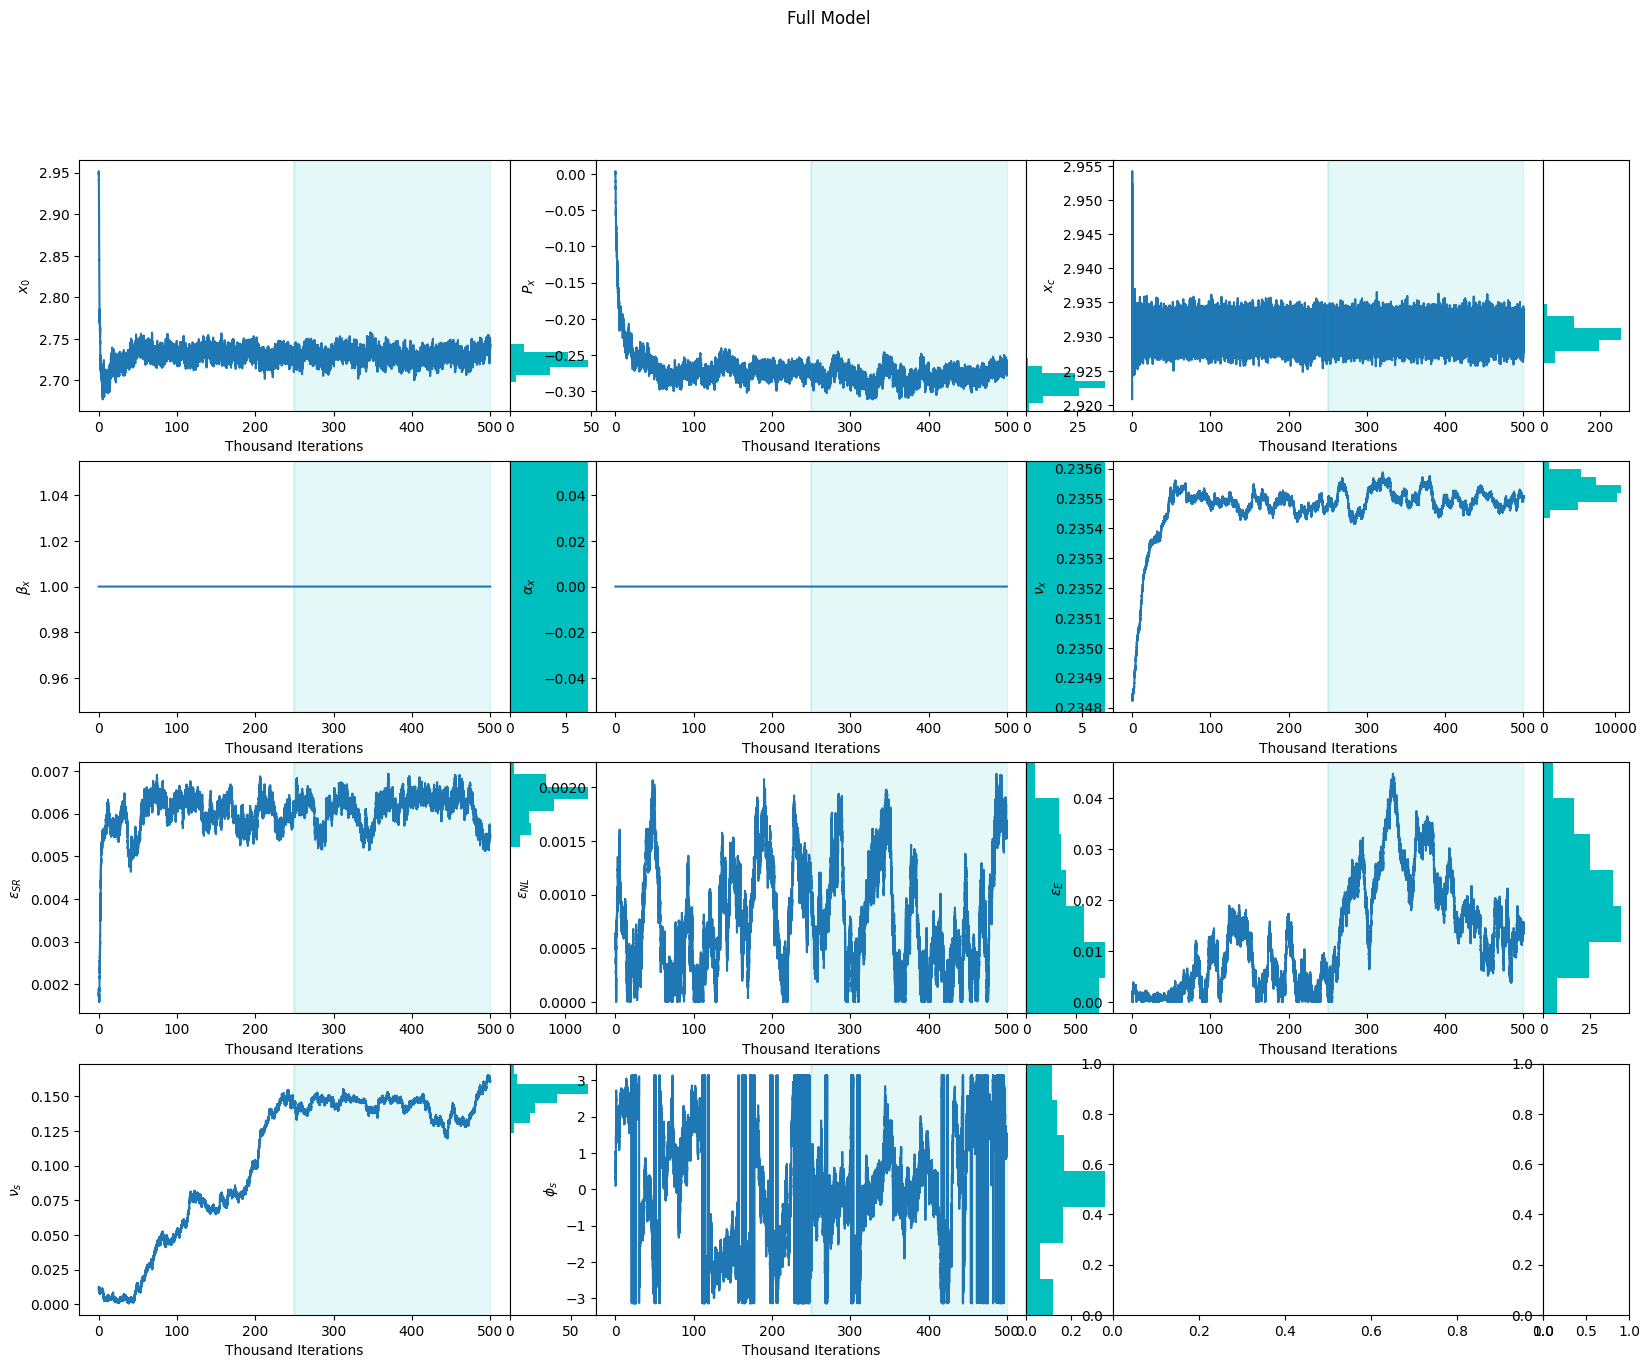

In [16]:
nrow = 4
ncol = 3
Theta_names = [r"$x_0$", r"$P_x$", r"$x_c$", r"$\beta_x$", r"$\alpha_x$", r"$\nu_x$", r"$\epsilon_{SR}$", 
              r"$\epsilon_{NL}$", r"$\epsilon_E$", r"$\nu_s$", r"$\phi_s$"]
N_var = len(Theta_names)
N_iter = len(parr)
fig, Ax = plt.subplots(nrow, ncol*2, gridspec_kw = {'width_ratios':[5, 1]*ncol}, figsize=(20, 15))
fig.suptitle('Full Model')
split = N_iter//2
x_iter = np.linspace(0, N_iter//1000, N_iter)
Center = []
Stddev = []

for i in range(nrow):
    for j in range(ncol):
        if i*ncol + j >= N_var:
            break
        target = parr.T[i*ncol + j]
        Ax[i][j*2].set_xlabel("Thousand Iterations")
        Ax[i][j*2].set_ylabel(Theta_names[i*ncol + j])
        Ax[i][j*2].plot(x_iter, target)
        Ax[i][j*2].axvspan(split/1000, N_iter/1000, alpha = 0.1, color = 'c')
        Ax[i][j*2].axvline(split/1000, color = 'c', alpha = 0.1)
        center, stddev = np.average(target[split:]), np.std(target[split:])
        Center.append(center)
        Stddev.append(stddev)
        
        hist_data,_,_ = Ax[i][j*2 + 1].hist(target[split:], orientation='horizontal', density=True, color='c', bins=7)
        Ax[i][j*2 + 1].set_xlim([0, np.max(hist_data)*1.1])
        Ax[i][j*2 + 1].set_ylim([np.min(target), np.max(target)])
        Ax[i][j*2 + 1].get_yaxis().set_visible(False)
        
        
plt.subplots_adjust(wspace=0.0)
plt.show()

[ 2.73054700e+00 -2.78669444e-01  2.93070395e+00  1.00000000e+00
  0.00000000e+00  2.35499736e-01  6.11730621e-03  7.70882896e-04
  2.06659007e-02  1.43235273e-01  1.20124844e-01]


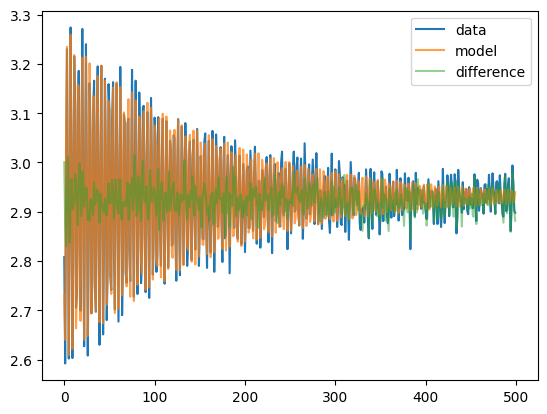

In [17]:
Center = np.array(Center)
Stddev = np.array(Stddev)
print(Center)

x_model = model(*Center, N_turns)
diff = BPMx0[initial: N_turns//2 + initial] - x_model[:N_turns//2] + BPMx0_mean
interval = 500#N_turns//2
initial = 35

plt.plot(BPMx0[initial: interval + initial], label = "data")
plt.plot(x_model[:interval], label = "model", alpha = .75)
plt.plot(diff[:interval], label = "difference", alpha = .5)

plt.legend()
plt.show()

In [12]:
#pinitials = [BPMx0[0], 0.0, BPMx0_mean, 1.0, 0, BPMx0_Tune_scipy, 0.0,  0.0, 0e-1, 8e-3, 0.1]
#p_step = [1e-3, 1e-3, 1e-3,  0,  0, 5e-7, 1e-6, 1e-6, 0e-3, 1e-4, 3e-3]
BPMY0 = np.abs(fft.rfft(BPMy[0])[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
pinitials = [BPMy[0, 0], 0.0, np.mean(BPMy[0]), 1.0, 0, BPMy0_Tune_scipy, 0.0,  0.0, 0, 1e-2, 0.5]
p_step = [1e-3, 1e-3, 1e-3,  0,  0, 5e-7, 0, 0, 0, 0, 0]
sinitials = [1e-2, 0e-2]
s_step = [2e-4, 0e-3]
initial = 535

pinitials[6] = 0.0018
pinitials[7] = 0.0006
pinitials[8] = 0.00073
pinitials[9] = 1e-2
pinitials[10] = 1
p_step[6] = 1e-5
p_step[7] = 1e-5
p_step[8] = 1e-4
p_step[9] = 1e-4
p_step[10] = 3e-2

N_iter = 150000
begin = time.time()
# parr : iters x 11; sarr = iters x 2
parr, sarr = metropolis_hastings(log_likelihood, BPMy0[initial: ], N_iter, 
                              pinitials, p_step, sinitials, s_step)
end = time.time()
print("Time elapsed for full model:", end - begin)

Time elapsed for full model: 27.35076403617859


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_41120/4185685204.py:30: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  Ax[i][j*2 + 1].set_ylim([np.min(target), np.max(target)])


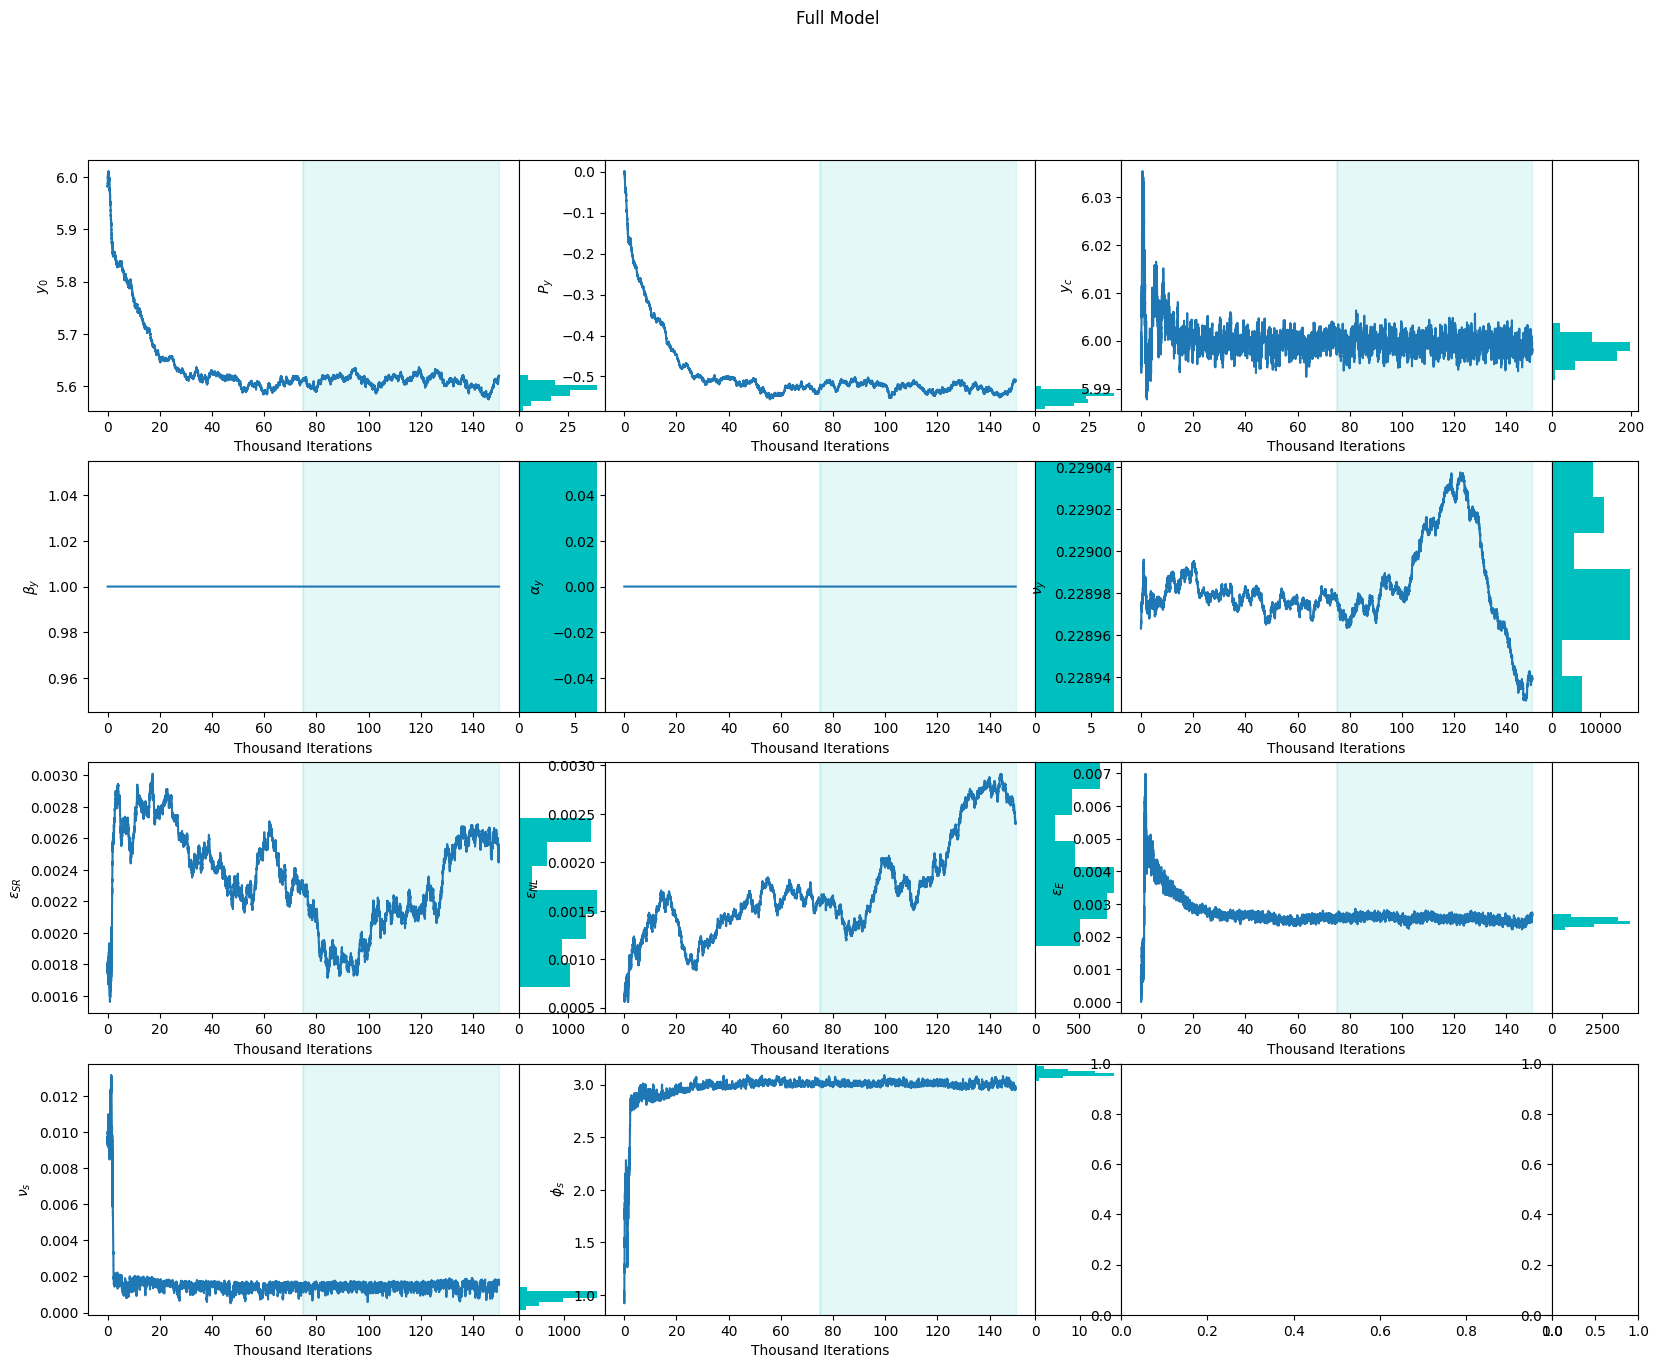

In [13]:
nrow = 4
ncol = 3
Theta_names = [r"$y_0$", r"$P_y$", r"$y_c$", r"$\beta_y$", r"$\alpha_y$", r"$\nu_y$", r"$\epsilon_{SR}$", 
              r"$\epsilon_{NL}$", r"$\epsilon_E$", r"$\nu_s$", r"$\phi_s$"]
N_var = len(Theta_names)
N_iter = len(parr)
fig, Ax = plt.subplots(nrow, ncol*2, gridspec_kw = {'width_ratios':[5, 1]*ncol}, figsize=(20, 15))
fig.suptitle('Full Model')
split = N_iter//2
x_iter = np.linspace(0, N_iter//1000, N_iter)
Center = []
Stddev = []

for i in range(nrow):
    for j in range(ncol):
        if i*ncol + j >= N_var:
            break
        target = parr.T[i*ncol + j]
        Ax[i][j*2].set_xlabel("Thousand Iterations")
        Ax[i][j*2].set_ylabel(Theta_names[i*ncol + j])
        Ax[i][j*2].plot(x_iter, target)
        Ax[i][j*2].axvspan(split/1000, N_iter/1000, alpha = 0.1, color = 'c')
        Ax[i][j*2].axvline(split/1000, color = 'c', alpha = 0.1)
        center, stddev = np.average(target[split:]), np.std(target[split:])
        Center.append(center)
        Stddev.append(stddev)
        
        hist_data,_,_ = Ax[i][j*2 + 1].hist(target[split:], orientation='horizontal', density=True, color='c', bins=7)
        Ax[i][j*2 + 1].set_xlim([0, np.max(hist_data)*1.1])
        Ax[i][j*2 + 1].set_ylim([np.min(target), np.max(target)])
        Ax[i][j*2 + 1].get_yaxis().set_visible(False)
        
        
plt.subplots_adjust(wspace=0.0)
plt.show()

[ 5.61025726e+00 -5.25806649e-01  5.99945132e+00  1.00000000e+00
  0.00000000e+00  2.28986283e-01  2.19319006e-03  2.00688145e-03
  2.55149619e-03  1.41838589e-03  3.00941264e+00]


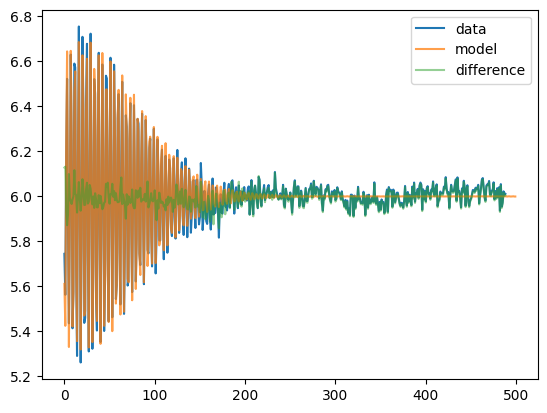

In [14]:
Center = np.array(Center)
Stddev = np.array(Stddev)
print(Center)

y_model = model(*Center, N_turns)
interval = 500#N_turns//2
initial = 535
diff = BPMy0[initial:] - y_model[:len(BPMy0[initial:])] + np.mean(BPMy[0])

plt.plot(BPMy0[initial: interval + initial], label = "data")
plt.plot(y_model[:interval], label = "model", alpha = .75)
plt.plot(diff[:interval], label = "difference", alpha = .5)

plt.legend()
plt.show()

In [51]:
filenamex_mean = "Theta_BPMx_mean_Data"
filenamex_err = "Theta_BPMx_err_Data"
filenamey_mean = "Theta_BPMy_mean_Data"
filenamey_err = "Theta_BPMy_err_Data"

for i in range(N_BPMx):
    BPMXi = np.abs(fft.rfft(BPMx[i])[1:])
    BPMxi_Tune_scipy = Omega[np.argmax(BPMXi)]
    pinitials_x = [BPMx[i, 0], 0.0, np.mean(BPMx[i]), 1.0, 0, BPMxi_Tune_scipy, 0,  0.0, 0, 1e-2, 0.5]
    p_step = [1e-3, 1e-3, 1e-3,  0,  0, 5e-7, 1e-4, 1e-5, 1e-5, 1e-4, 3e-2]
    sinitials = [1e-2, 0e-2]
    s_step = [2e-4, 0e-3]
    initial_x = 35
    N_iter = 60000
    begin = time.time()
    # parr : iters x 11; sarr = iters x 2
    parr, sarr = metropolis_hastings(log_likelihood, BPMx[i, initial_x: N_turns//2 + initial_x], N_iter, 
                                  pinitials_x, p_step, sinitials, s_step)
    end = time.time()
    print("Time elapsed for horizontal BPM %d:"%(i + 1), end - begin)
    with open(filenamex_mean, 'a') as csvfilex_mean:
        writerx_mean = csv.writer(csvfilex_mean, delimiter=',')
        writerx_mean.writerow(np.mean(parr.T[:, N_iter//2:], axis = 1))
    with open(filenamex_err, 'a') as csvfilex_err:
        writerx_err = csv.writer(csvfilex_err, delimiter=',')
        writerx_err.writerow(np.std(parr.T[:, N_iter//2:], axis = 1))
    
    if i < N_BPMy:
        BPMYi = np.abs(fft.rfft(BPMy[i])[1:])
        BPMyi_Tune_scipy = Omega[np.argmax(BPMYi)]
        pinitials_y = [BPMy[i, 0], 0.0, np.mean(BPMy[i]), 1.0, 0, BPMyi_Tune_scipy, 0,  0.0, 0, 1e-2, 0.5]
        initial_y = 535
        begin = time.time()
        # parr : iters x 11; sarr = iters x 2
        parr, sarr = metropolis_hastings(log_likelihood, BPMy[i, initial_y:], N_iter, 
                                      pinitials_y, p_step, sinitials, s_step)
        end = time.time()
        print("Time elapsed for vertical BPM %d:"%(i + 1), end - begin)
        with open(filenamey_mean, 'a') as csvfiley_mean:
            writery_mean = csv.writer(csvfiley_mean, delimiter=',')
            writery_mean.writerow(np.mean(parr.T[:, N_iter//2:], axis = 1))
        with open(filenamey_err, 'a') as csvfiley_err:
            writery_err = csv.writer(csvfiley_err, delimiter=',')
            writery_err.writerow(np.std(parr.T[:, N_iter//2:], axis = 1))



Time elapsed for horizontal BPM 1: 12.64504623413086


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_41120/4230582586.py:22: RuntimeWarning: overflow encountered in multiply
  return -np.sum(diff*diff/2.0/ss) - np.sum(np.log(np.sqrt(ss)))#*len(diff)
/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_41120/4230582586.py:22: RuntimeWarning: overflow encountered in divide
  return -np.sum(diff*diff/2.0/ss) - np.sum(np.log(np.sqrt(ss)))#*len(diff)


Time elapsed for vertical BPM 1: 14.5186607837677
Time elapsed for horizontal BPM 2: 15.729594945907593
Time elapsed for vertical BPM 2: 15.217079877853394
Time elapsed for horizontal BPM 3: 16.602648973464966


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_41120/4230582586.py:13: RuntimeWarning: overflow encountered in exp
  decay = np.exp(-(alpha**2 - alpha02)/2 - (eps_nl*turns)**2 - eps_sr*turns)


Time elapsed for vertical BPM 3: 18.068007946014404
Time elapsed for horizontal BPM 4: 15.568222999572754
Time elapsed for vertical BPM 4: 17.105830907821655
Time elapsed for horizontal BPM 5: 14.835018873214722
Time elapsed for vertical BPM 5: 14.03769588470459
Time elapsed for horizontal BPM 6: 12.807615041732788
Time elapsed for vertical BPM 6: 11.192772150039673
Time elapsed for horizontal BPM 7: 19.781705856323242
Time elapsed for vertical BPM 7: 12.32469916343689
Time elapsed for horizontal BPM 8: 13.64329195022583
Time elapsed for vertical BPM 8: 15.673357009887695
Time elapsed for horizontal BPM 9: 17.248823165893555
Time elapsed for vertical BPM 9: 14.135841131210327
Time elapsed for horizontal BPM 10: 15.777000188827515
Time elapsed for vertical BPM 10: 10.025228023529053
Time elapsed for horizontal BPM 11: 10.700592994689941
Time elapsed for vertical BPM 11: 10.653128862380981
Time elapsed for horizontal BPM 12: 11.024546146392822
Time elapsed for vertical BPM 12: 8.69471120

/Users/GrandmasterFung/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Time elapsed for vertical BPM 57: 11.904797792434692
Time elapsed for horizontal BPM 58: 11.136003971099854
Time elapsed for vertical BPM 58: 12.915117979049683
Time elapsed for horizontal BPM 59: 9.934075117111206
Time elapsed for vertical BPM 59: 10.318351745605469
Time elapsed for horizontal BPM 60: 14.697899103164673
Time elapsed for vertical BPM 60: 9.123219013214111
Time elapsed for horizontal BPM 61: 13.299028158187866
Time elapsed for vertical BPM 61: 13.010474920272827
Time elapsed for horizontal BPM 62: 14.742693901062012
Time elapsed for vertical BPM 62: 10.89516806602478
Time elapsed for horizontal BPM 63: 14.289644956588745
Time elapsed for vertical BPM 63: 17.06448793411255
Time elapsed for horizontal BPM 64: 18.73070502281189
Time elapsed for vertical BPM 64: 15.841694831848145
Time elapsed for horizontal BPM 65: 16.207019090652466
Time elapsed for vertical BPM 65: 13.489315748214722
Time elapsed for horizontal BPM 66: 14.337587118148804
Time elapsed for vertical BPM 66:

Time elapsed for vertical BPM 133: 9.305782079696655
Time elapsed for horizontal BPM 134: 10.537766933441162
Time elapsed for vertical BPM 134: 11.642035961151123
Time elapsed for horizontal BPM 135: 10.303346872329712
Time elapsed for vertical BPM 135: 9.435452938079834
Time elapsed for horizontal BPM 136: 9.922338724136353
Time elapsed for vertical BPM 136: 9.503641843795776
Time elapsed for horizontal BPM 137: 10.083226203918457
Time elapsed for vertical BPM 137: 9.022902011871338
Time elapsed for horizontal BPM 138: 9.2880277633667
Time elapsed for vertical BPM 138: 9.083338975906372
Time elapsed for horizontal BPM 139: 9.481194019317627
Time elapsed for vertical BPM 139: 8.954355001449585
Time elapsed for horizontal BPM 140: 12.088478088378906
Time elapsed for vertical BPM 140: 11.643530130386353
Time elapsed for horizontal BPM 141: 11.978898763656616
Time elapsed for vertical BPM 141: 11.568439960479736
Time elapsed for horizontal BPM 142: 11.398399353027344
Time elapsed for vert

In [98]:
def Jbeta(X, Px, N_BPMs, Bad_bpms):
    res = X**2 + Px**2

    # Get rid of bad bpms
    for i in Bad_bpms:
        # Look for the nearest good bpm neighbors and take the average:
        lo, hi = i, i
        while lo in Bad_bpms: 
            lo -= 1
            if lo < 0: lo = N_BPMs - 1
        while hi in Bad_bpms: 
            hi += 1
            if hi >= N_BPMs: hi = 0
        res[i] = (res[lo] + res[hi])/2
    return res

#Error Propagation
def Jbeta_error(X, Px, X_err, Px_err, N_BPMs, Bad_bpms, err_lim):
    A = np.sqrt(Jbeta(X, Px, N_BPMs, Bad_bpms))
    error = X_err**2*(X/A)**2 + Px_err**2*(Px/A)**2
    LargeErrorBPM = np.zeros(len(X))
    for i in range(len(error)):
        if error[i] > err_lim:
            LargeErrorBPM[i] = 1
    return np.sqrt(error), LargeErrorBPM

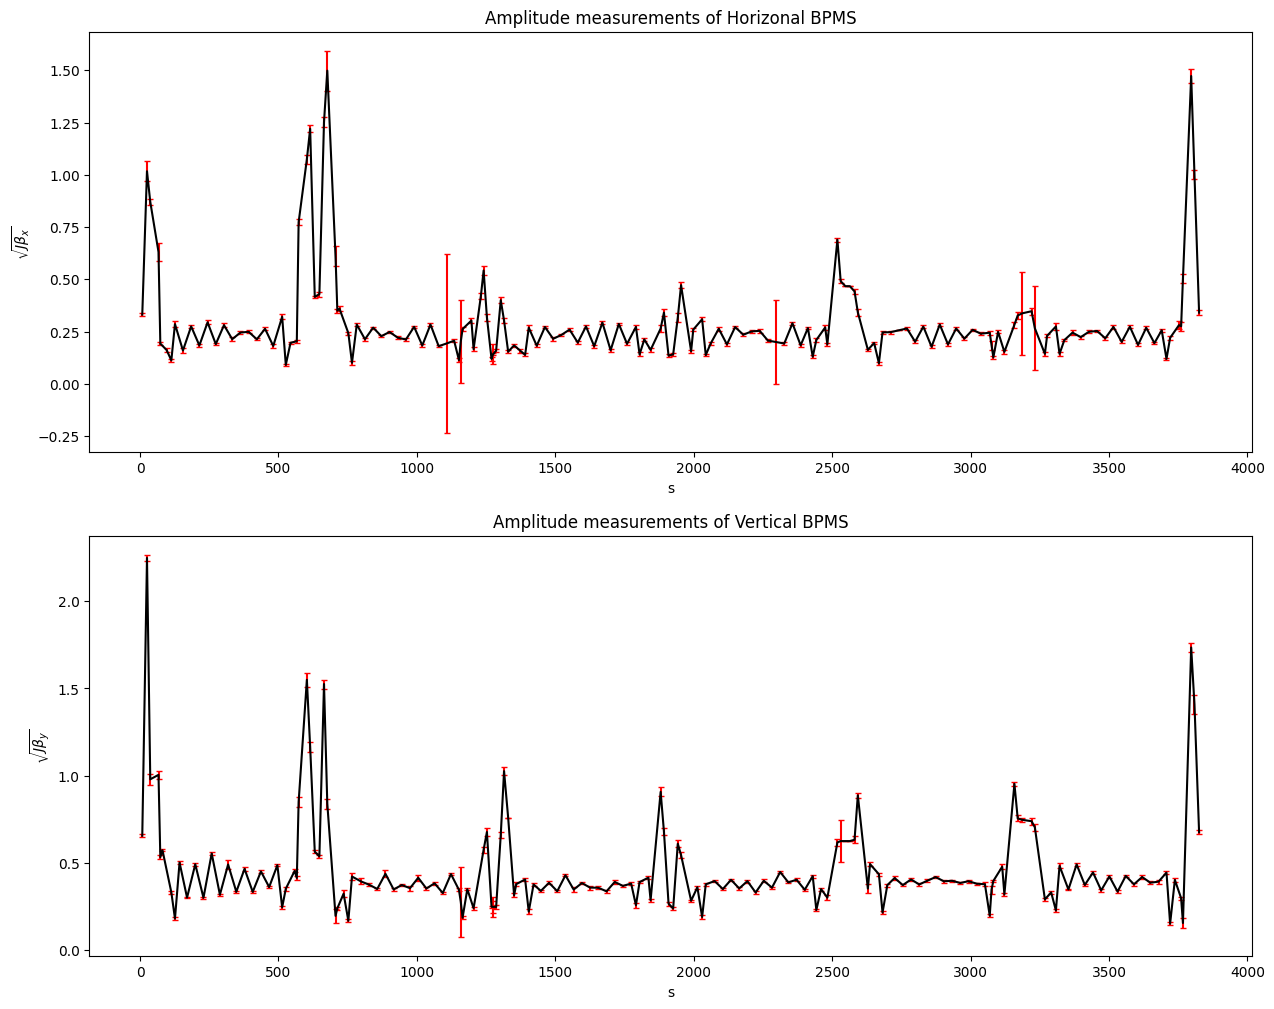

In [106]:
with open(filenamex_mean, newline = "") as csvfilex_mean:
    Theta_final_x = np.array(list(csv.reader(csvfilex_mean, delimiter=',')), dtype=float)
with open(filenamey_mean, newline = "") as csvfiley_mean:
    Theta_final_y = np.array(list(csv.reader(csvfiley_mean, delimiter=',')), dtype=float)
with open(filenamex_err, newline = "") as csvfilex_err:
    Theta_final_x_err = np.array(list(csv.reader(csvfilex_err, delimiter=',')), dtype=float)
with open(filenamey_err, newline = "") as csvfiley_err:
    Theta_final_y_err = np.array(list(csv.reader(csvfiley_err, delimiter=',')), dtype=float)

fig, Ax = plt.subplots(2, 1, figsize = (15, 12))
X, Px = Theta_final_x.T[:2]
Y, Py = Theta_final_y.T[:2]
X_err, Px_err = Theta_final_x_err.T[:2]
Y_err, Py_err = Theta_final_y_err.T[:2]
err_lim = .2

BPMx_Jbeta_Map = np.sqrt(Jbeta((X - np.mean(BPMx, axis = 1)), Px, N_BPMx, Bad_BPMx))
BPMy_Jbeta_Map = np.sqrt(Jbeta((Y - np.mean(BPMy, axis = 1)), Py, N_BPMy, Bad_BPMy))
BPMx_Jbeta_Map_err, LargeErrorBPMx = Jbeta_error(X, Px, X_err, Px_err, N_BPMx, Bad_BPMx, err_lim)
BPMy_Jbeta_Map_err, LargeErrorBPMy = Jbeta_error(Y, Py, Y_err, Py_err, N_BPMx, Bad_BPMy, err_lim)
BPMx_Jbeta_Map_err_plot, BPMy_Jbeta_Map_err_plot = np.copy(BPMx_Jbeta_Map_err), np.copy(BPMy_Jbeta_Map_err)
for i, status in enumerate(LargeErrorBPMx):
    if status == 1: BPMx_Jbeta_Map_err_plot[i] = err_lim
for i, status in enumerate(LargeErrorBPMy):
    if status == 1: BPMy_Jbeta_Map_err_plot[i] = err_lim
Ax[0].errorbar(S_xbpms[0], BPMx_Jbeta_Map, yerr = BPMx_Jbeta_Map_err_plot, color = 'k', ecolor = 'r', capsize = 2)
Ax[0].set_xlabel("s")
Ax[0].set_ylabel(r"$\sqrt{J\beta_x}$")
Ax[0].set_title(r"Amplitude measurements of Horizonal BPMS")
Ax[1].errorbar(S_ybpms[0], BPMy_Jbeta_Map, yerr = BPMy_Jbeta_Map_err_plot, color = 'k', ecolor = 'r', capsize = 2)
Ax[1].set_xlabel("s")
Ax[1].set_ylabel(r"$\sqrt{J\beta_y}$")
Ax[1].set_title(r"Amplitude measurements of Vertical BPMS")
plt.show()

# Betatron Function around IP8

## Method 1:
Determine constant J from $\beta = \frac{A}{J}$

\begin{equation*}
M_{drift} = 
\begin{bmatrix}
C & S\\
C' & S'
\end{bmatrix}
=
\begin{bmatrix}
1 & L\\
0 & 1
\end{bmatrix}
\end{equation*}

\begin{equation*}
\Rightarrow
M_{twiss} = 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\end{equation*}

Between BPM 27 and BPM 28:
\begin{equation*}
\begin{bmatrix}
\beta_2 \\
\alpha_f \\
\gamma_f \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\alpha_i \\
\gamma_i \\
\end{bmatrix}
\end{equation*}

$\Rightarrow \beta_2 = \beta_1 - 2L\alpha_i + L^2 \gamma_i$\
$\Rightarrow \alpha_1 = \frac{\beta_1}{L} \pm \sqrt{\frac{\beta_1\beta_2}{L^2} - 1}$\
$\Rightarrow \alpha_2 = \alpha_1 - L\gamma_1$\
Where $\gamma_1 = \frac{1 + \alpha_1^2}{\beta_1}$

Between BPM 26 and BPM 27:\
\begin{equation*}
\begin{bmatrix}
\beta_1 \\
\alpha_1 \\
\gamma_1 \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\alpha_i \\
\gamma_i \\
\end{bmatrix}
\end{equation*}
$\Rightarrow 0 = \beta_1 - \beta_0 - 2L\alpha_1 - L^2 \gamma_1$


Or between BPM 28 and BPM 29:\
\begin{equation*}
\begin{bmatrix}
\beta_3 \\
\alpha_f \\
\gamma_f \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_2 \\
\alpha_2 \\
\gamma_2 \\
\end{bmatrix}
\end{equation*}
$\Rightarrow 0 = \beta_2 - \beta_3 - 2L\alpha_2 + L^2 \gamma_2$

Since everything is known except J, solve for a using some root finding method

This method doesn't work since we cannot fit the constant perfectly; the machine is not perfect. Therefore root finding methods will not work if the algorithm relies on fitting for too many points.

5163.243975521833 244.4538505294221
5163.243975521833


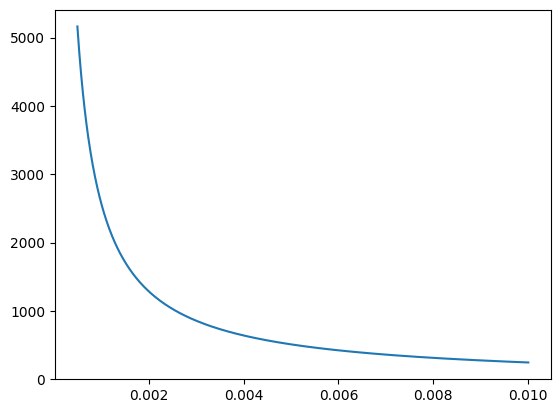

ValueError: f(a) and f(b) must have different signs

In [57]:
s_bo7_b1 = S_xbpms[0, 26]
s_g7_bx = S_xbpms[0, 27]
s_g8_bx = S_xbpms[0, 28]
s_bi8_b1 = S_xbpms[0, 29]
L26_27 = abs(s_g7_bx - s_bo7_b1)
L27_28 = abs(s_g8_bx - s_g7_bx)
L28_29 = abs(s_bi8_b1 - s_g8_bx)

def f(J):
    b26 = (BPMx_Jbeta_Map[26]/J)
    b27 = (BPMx_Jbeta_Map[27]/J)
    b28 = (BPMx_Jbeta_Map[28]/J)
    b29 = (BPMx_Jbeta_Map[29]/J)
    alpha27 = b27/L27_28 + np.sqrt((b27*b28/L27_28**2 - 1))
    gamma27 = (1 + alpha27**2)/b27
    alpha28 = alpha27 - L27_28*gamma27
    gamma28 = (1 + alpha28**2)/b28
    return b28 - b29 - 2*L28_29*alpha28 + L28_29**2*gamma28
#     return b26 - b27 - 2*L26_27*alpha27 - L26_27**2*gamma27
    

J_const = np.linspace(.0005, .1, 1000)
f_j = f(J_const)
f_j = f_j[np.logical_not(np.isnan(f_j))]
N_f_j = len(f_j)
print(f_j[0], f_j[-1])
print(np.max(f_j))
plt.plot(J_const, f(J_const))
plt.show()

J_opt = optimize.bisect(f, J_const[0], J_const[-1])
print(J_opt)

After trying to fit the constant, determine b* and s* and fit a parabola onto the curve using the three points:\
($s_{g7-bx}, \beta(s_{g7-bx}$)), ($s^*, \beta^*$), ($s_{g8-bx}$, $\beta(s_{g8-bx}$)). \
This part of the method is ok to use for later methods.

In [56]:
# Determine Betatron function:
J_const = J_opt 
beta_BPM27, beta_BPM28 = (BPMx_Jbeta_Map[27]/J_const), (BPMx_Jbeta_Map[28]/J_const)
alpha_BPM27 = beta_BPM27/L27_28 + np.sqrt(beta_BPM27*beta_BPM28/L27_28**2 - 1)
display(Math(r"\beta_{27} = %f"%beta_BPM27))
display(Math(r"\alpha_{27} = %f"%alpha_BPM27))
display(Math(r"\beta_{28} = %f"%beta_BPM28))
 
s_star = s_g7_bx + alpha_BPM27*beta_BPM27/(alpha_BPM27**2 + 1)
beta_star = beta_BPM27/(alpha_BPM27**2 + 1)
display(Math(r"\beta^* = %f"%beta_star))
display(Math(r"s^* = %f"%s_star))
sIP8 = 639.445027949618
display(Math(r"\Delta s^* = %f"%(s_star - sIP8)))

def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
    return A,B,C
A, B, C = calc_parabola_vertex(s_g7_bx, beta_BPM27, s_star, beta_star, s_g8_bx, beta_BPM28)
A_shift, B_shift, C_shift = calc_parabola_vertex(s_g7_bx - s_star, beta_BPM27, 0, beta_star, s_g8_bx - s_star, beta_BPM28)
print()
print("After shift:")
display(Math(r"%fx^2 + %dx + %f"%(A_shift, B_shift, C_shift)))

s_space = np.linspace(s_g7_bx, s_g8_bx, 1000)
Betatron = A*s_space**2 + B*s_space + C
plt.plot([s_g7_bx, s_star, s_g8_bx], [beta_BPM27, beta_star, beta_BPM28], 'o')
for x, y, text in zip([s_g7_bx, s_star, s_g8_bx], [beta_BPM27, beta_star, beta_BPM28], 
                      [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.plot(s_space, Betatron)
plt.title("Betatron function using BPMs")
plt.xlabel("s")
plt.ylabel(r"$\beta$(s)")
plt.show()

/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_41120/3365529167.py:4: RuntimeWarning: invalid value encountered in sqrt
  alpha_BPM27 = beta_BPM27/L27_28 + np.sqrt(beta_BPM27*beta_BPM28/L27_28**2 - 1)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


After shift:


ValueError: cannot convert float NaN to integer

## Method 2:
This method uses curve_fit to fit four points:

($s_{bo7_b1}, \beta(s_{bo7_b1}$)), ($s_{g7-bx}, \beta(s_{g7-bx}$)), ($s_{g8-bx}$, $\beta(s_{g8-bx}$)), ($s_{bi8_b1}$, $\beta(s_{bi8_b1}$))

to a general parabola. This method is not that great since the shape between the two BPMs near IP may not depend on the ones next to it.

In [58]:
def model(x, A, B, C): 
    return A*x**2 + B*x + C 
X = np.array([s_bo7_b1, s_g7_bx, s_g8_bx, s_bi8_b1])
Y = BPMx_Jbeta_Map[26:30]
Fit, Covar, = optimize.curve_fit(model, X, Y)
print(Fit)
print(Covar)

[ 1.46152741e-03 -1.86847536e+00  5.97504494e+02]
[[ 6.36610181e-12 -8.14154356e-09  2.60082069e-06]
 [-8.14154356e-09  1.04135573e-05 -3.32707089e-03]
 [ 2.60082069e-06 -3.32707089e-03  1.06312555e+00]]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

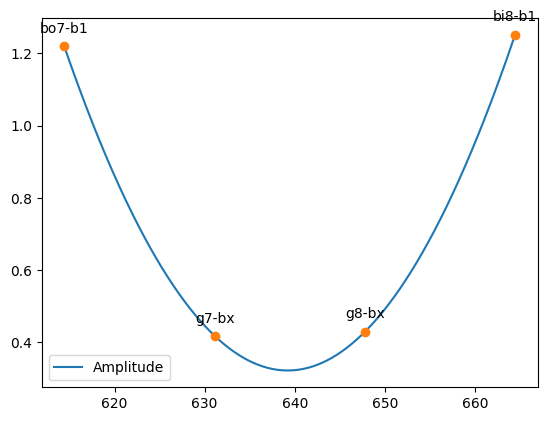

12.656620502351263


In [59]:
s_space = np.linspace(s_bo7_b1, s_bi8_b1, 1000)
Betatron = Fit[0]*s_space**2 + Fit[1]*s_space + Fit[2]
s_star = s_space[np.argmin(Betatron)]
display(Math(r"s^* = %f"%s_star))
display(Math(r"\Delta s^* = %f"%(s_star - sIP8)))
plt.plot(s_space, Betatron, label = 'Amplitude')
plt.plot(X, Y, 'o')
for x, y, text in zip(X, Y, Name_xbpms[26:30]):
    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
# plt.axvline(x = s_star, color = 'black', label = 's*')
# plt.axvline(x = mid, color = 'blue', label = 'mid')
plt.legend()
plt.show()
print(Betatron[np.argmin(Betatron)]/J_opt)

## Method 3:
Solve for three nonlinear equations and three unknowns: $\beta^*, s^*, J$\
Using:\
0 = $\beta^* + (s_{g7-bx} - s^*)^2/\beta^* - \beta(s_{g7-bx})$\
0 = $\beta^* + (s_{g8-bx} - s^*)^2/\beta^* - \beta(s_{g8-bx})$\
$\alpha_{g7-bx} = (s^* - s_{g7-bx})/\beta^*$\
0 = $\sqrt{|\beta(s_{g7-bx})\beta(s_{g8-bx}) - 1|} - (\alpha_{g7-bx} - \beta(s_{g7-bx})/L_{27-28}))$

Third equation comes from alpha equation from method 1.\
This method uses only information from g7-bx and g8-bx.\
It produces many solutions based on the guess of $\beta^*$ and a, so look at L2 error of each combination.\
Look at the result with the lowest error first. Then create histograms and weighted histograms to see where the solution should be. The average and standard deviations after weighting with the L2 error should be a more accurate picture of where the solution lies.

In [144]:
filenamex_mean2 = "Theta_BPMx_mean_Data_2point"
filenamex_err2 = "Theta_BPMx_err_Data_2point"

for i in range(27, 29):
    BPMXi = np.abs(fft.rfft(BPMx[i])[1:])
    BPMxi_Tune_scipy = Omega[np.argmax(BPMXi)]
    pinitials_x = [BPMx[i, 0], 0.0, np.mean(BPMx[i]), 1.0, 0, BPMxi_Tune_scipy, 0,  0.0, 0, 1e-2, 0.5]
    p_step = [1e-3, 1e-3, 1e-3,  0,  0, 5e-7, 1e-4, 1e-5, 1e-5, 1e-4, 3e-2]
    sinitials = [1e-2, 0e-2]
    s_step = [2e-4, 0e-3]
    initial_x = 35
    N_iter = 100000
    begin = time.time()
    # parr : iters x 11; sarr = iters x 2
    parr, sarr = metropolis_hastings(log_likelihood, BPMx[i, initial_x: N_turns//2 + initial_x], N_iter, 
                                  pinitials_x, p_step, sinitials, s_step)
    end = time.time()
    print("Time elapsed for horizontal BPM %d:"%(i + 1), end - begin)
    with open(filenamex_mean2, 'a') as csvfilex_mean:
        writerx_mean = csv.writer(csvfilex_mean, delimiter=',')
        writerx_mean.writerow(np.mean(parr.T[:, N_iter//2:], axis = 1))
    with open(filenamex_err2, 'a') as csvfilex_err:
        writerx_err = csv.writer(csvfilex_err, delimiter=',')
        writerx_err.writerow(np.std(parr.T[:, N_iter//2:], axis = 1))

with open(filenamex_mean2, newline = "") as csvfilex_mean:
    Theta_final_x2 = np.array(list(csv.reader(csvfilex_mean, delimiter=',')), dtype=float)
with open(filenamex_err2, newline = "") as csvfilex_err:
    Theta_final_x_err2 = np.array(list(csv.reader(csvfilex_err, delimiter=',')), dtype=float)

X, Px = Theta_final_x2.T[:2]
X_err, Px_err = Theta_final_x_err2.T[:2]

BPMx_Jbeta_Map2 = np.sqrt(Jbeta((X - np.mean(BPMx[27:29], axis = 1)), Px, 2, []))
BPMx_Jbeta_Map_err2, LargeErrorBPMx2 = Jbeta_error(X, Px, X_err, Px_err, 2, [], err_lim)

Time elapsed for horizontal BPM 28: 19.725057125091553
Time elapsed for horizontal BPM 29: 18.52838110923767


In [185]:
s_MADx = []
Betax_MADx = []
with open('twiss.out_Au23-100GeV-e0-beta5') as output:
    Lines = output.readlines()
    for i, line in enumerate(Lines[48:]):
        Line = re.split("\s+", line)
        Line[1] = Line[1].replace('_', '-')[1:-1]
        if Line[1] in np.char.upper(Name_xbpms) or Line[1] == 'BI9-B3.1': # because it is BI9-BH3.1 in the measurement file
            s_MADx.append(float(Line[2]))
            Betax_MADx.append(float(Line[3]))

s_MADx = np.array(s_MADx)
Betax_MADx = np.array(Betax_MADx)
# print(s_MADx)
# print(Betax_MADx[:20])
#print(Name_xbpms)
BetaArc = []
AmpArc = []
sArc = []
for i, name in enumerate(Name_xbpms):
    if name[0] != 'g' and name[-4:-2] == "bh" and int(name[-2:]) >= 10:
        #print(name)
        BetaArc.append(Betax_MADx[i])
        AmpArc.append(BPMx_Jbeta_Map[i])
        sArc.append(s_MADx[i])

        
BetaArc = np.array(BetaArc)
AmpArc = np.array(AmpArc)
J_g = (sum(AmpArc)/sum(BetaArc))
print(J_g)

0.005284123621289256


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_41120/173021233.py:11: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt((b27*b28/L27_28**2 - 1)) - ((sstar - s_g7_bx)/bstar - b27/L27_28)])


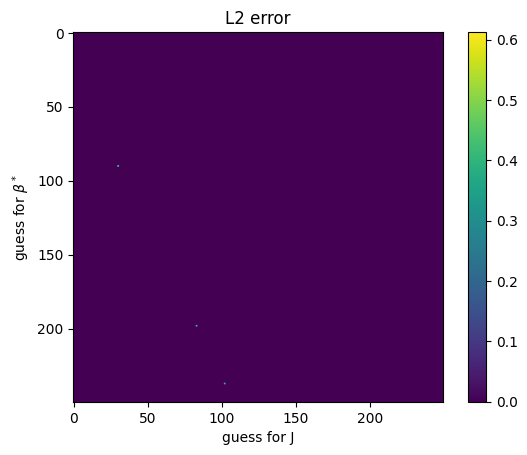

Lowest error result


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [195]:
sIP8 = 639.445027949618
L27_28 = abs(s_g8_bx - s_g7_bx)

def f2(x):
    sstar, bstar, J = x
    b27 = BPMx_Jbeta_Map2[0]/J#(BPMx_Jbeta_Map[27]/J)
    b28 = BPMx_Jbeta_Map2[1]/J#(BPMx_Jbeta_Map[28]/J)
    return np.array([
           bstar + (s_g7_bx - sstar)**2/bstar - b27, 
           bstar + (s_g8_bx - sstar)**2/bstar - b28,
           np.sqrt((b27*b28/L27_28**2 - 1)) - ((sstar - s_g7_bx)/bstar - b27/L27_28)])

#accuracy:
N_b = 250
N_J = 250

Bguess = np.linspace(.4, .8, N_b)
Jguess = np.linspace(J_g - .0025, J_g + .0025, N_J)
Err = np.zeros([N_b, N_J])

Sstar = np.zeros([N_b, N_J])
Bstar = np.zeros([N_b, N_J])
Jconst = np.zeros([N_b, N_J])
for i, b in enumerate(Bguess):
    for j, J in enumerate(Jguess):
        sstar, bstar, jconst = optimize.fsolve(f2, [sIP8, b, J])
        Err[i, j] = np.sqrt(np.sum((f2([sstar, bstar, jconst]))**2))
        Sstar[i, j] = sstar
        Bstar[i, j] = bstar
        Jconst[i, j] = jconst
c = plt.imshow(Err)
plt.title("L2 error")
plt.xlabel("guess for J")
plt.ylabel(r"guess for $\beta^*$")
plt.colorbar(c)
plt.show()

b_ind, j_ind = np.unravel_index(np.argmin(Err), Err.shape)
sstar_LE, bstar_LE, jconst_LE = optimize.fsolve(f2, [sIP8, Bguess[b_ind], Jguess[j_ind]])
print("Lowest error result")
display(Math(r"s^* = %f, \beta^* = %f, J = %f"%(sstar_LE, bstar_LE, jconst_LE)))
display(Math(r"\Delta s^* = %f"%(sstar - sIP8)))

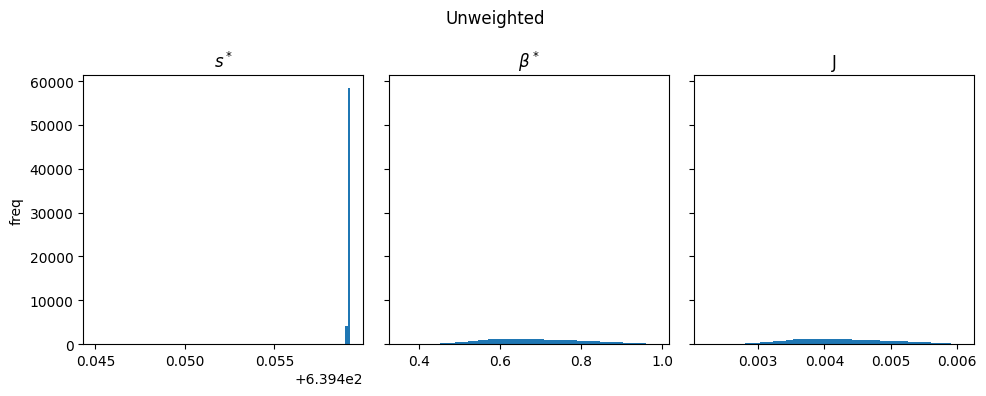

Stats:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [196]:
bins = 100
fig, axs = plt.subplots(1, 3, sharey = True, tight_layout=True, figsize = (10, 4))
plt.suptitle("Unweighted")
axs[0].hist(Sstar.flatten(), bins)
axs[1].hist(Bstar.flatten(), bins)
axs[2].hist(Jconst.flatten(), bins)
axs[0].set_ylabel("freq")
axs[0].set_title(r"$s^*$")
axs[1].set_title(r"$\beta^*$")
axs[2].set_title("J")
plt.show()
print("Stats:")

display(Math("\overline{s}^* = %f \pm %f"% (np.mean(Sstar), np.std(Sstar))))
display(Math(r"\overline{\beta}^* = %f \pm %f"% (np.mean(Bstar), np.std(Bstar))))
display(Math(r"\overline{J} = %f \pm %f"% (np.mean(Jconst), np.std(Jconst))))
display(Math(r"\Delta s^* = %f \pm %f"% (np.mean(Sstar) - sIP8, np.std(Sstar))))

#Method1Parabola(np.mean(Sstar), np.mean(Bstar), np.mean(Jconst), "Betatron function of Average Results")


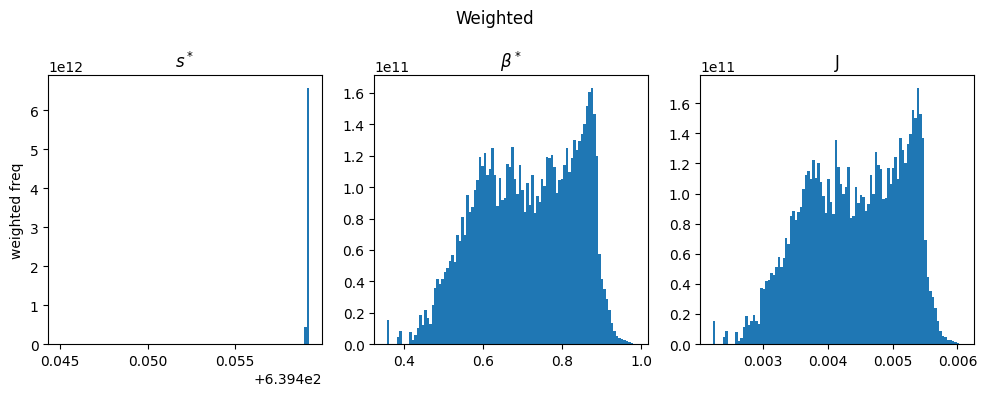

Weighted Stats:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [197]:
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize = (10, 4))
plt.suptitle("Weighted")
weight = 1/(Err.flatten() + 1e-10)
freq_Sstar_weight, bins_Sstar_weight, _ = axs[0].hist(Sstar.flatten(), bins, weights = weight)#, density = True)
freq_Bstar_weight, bins_Bstar_weight, _ = axs[1].hist(Bstar.flatten(), bins, weights = weight)#, density = True)
freq_Jconst_weight, bins_Jconst_weight, _ = axs[2].hist(Jconst.flatten(), bins, weights = weight)#, density = True)
axs[0].set_ylabel("weighted freq")
axs[0].set_title(r"$s^*$")
axs[1].set_title(r"$\beta^*$")
axs[2].set_title("J")
#axs[2].set_xlim([0, .1])
plt.show()

# Find mean and stddev of three plots
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)
print("Weighted Stats:")
sstar_avg_weighted, sstar_stddev_weighted = weighted_avg_and_std(bins_Sstar_weight[:-1], freq_Sstar_weight)
Bstar_avg_weighted, Bstar_stddev_weighted = weighted_avg_and_std(bins_Bstar_weight[:-1], freq_Bstar_weight)
Jconst_avg_weighted, Jconst_stddev_weighted = weighted_avg_and_std(bins_Jconst_weight[:-1], freq_Jconst_weight)
display(Math("\overline{s}^* = %f \pm %f"% (sstar_avg_weighted, sstar_stddev_weighted)))
display(Math(r"\overline{\beta}^* = %f \pm %f"% (Bstar_avg_weighted, Bstar_stddev_weighted)))
display(Math(r"\overline{J} = %f \pm %f"% (Jconst_avg_weighted, Jconst_stddev_weighted)))
display(Math(r"\Delta s^* = %f \pm %f"% (sstar_avg_weighted - sIP8, sstar_stddev_weighted)))


<IPython.core.display.Math object>

639.4591520543443 639.459095817202
0.7080790634558741 0.7085513486768484
Propagated error based on varying bpm27&28:  0.5129370736147982 0.06908112849967211


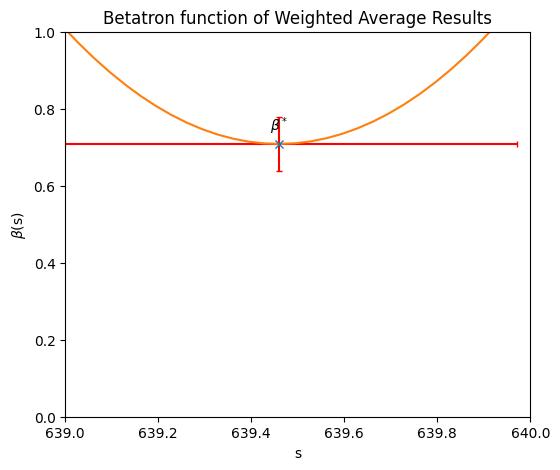

In [208]:
fig, Ax = plt.subplots(figsize = (6, 5))
beta_BPM27, beta_BPM28 = BPMx_Jbeta_Map2/Jconst_avg_weighted #(BPMx_Jbeta_Map[27]/Jconst_avg_weighted), (BPMx_Jbeta_Map[28]/Jconst_avg_weighted)
A, B, C = calc_parabola_vertex(s_g7_bx, beta_BPM27, sstar_avg_weighted, Bstar_avg_weighted, s_g8_bx, beta_BPM28)
A_shift, B_shift, C_shift = calc_parabola_vertex(s_g7_bx - sstar_avg_weighted, beta_BPM27, 0, Bstar_avg_weighted, s_g8_bx - sstar_avg_weighted, beta_BPM28)
display(Math(r"\beta(s) = %fs^2 + %ds + %f"%(A_shift, B_shift, C_shift)))

s_space = np.linspace(s_g7_bx, s_g8_bx, 500)
Betatron = A*s_space**2 + B*s_space + C
s_points = [s_g7_bx, sstar_avg_weighted, s_g8_bx]
b_points = [beta_BPM27, Bstar_avg_weighted, beta_BPM28]

for x, y, text in zip(s_points, b_points, 
                      [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):
    Ax.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
err_ypoints = np.zeros(3)
err_xpoints = np.zeros(3)

## Error Propagation on beta(s) = A/J
## s_b = sqrt((s_A*(1/J))^2 + (s_J*(-A/J^2))^2)
err_ypoints_beta = np.sqrt((BPMx_Jbeta_Map_err2*(1/Jconst_avg_weighted))**2 + (Jconst_stddev_weighted*BPMx_Jbeta_Map2/Jconst_avg_weighted**2)**2)
def error_prop_bsstar(b27, b28, b27_err, b28_err):
    a27 = b27/L27_28 + np.sqrt(b27*b28/L27_28**2 - 1)
    da27db27 = 1/L27_28 + b28/(2*L27_28**2*np.sqrt((b28*b27)/L27_28**2 - 1))
    da27db28 = b27/(2*L27_28**2*np.sqrt((b28*b27)/L27_28**2 - 1))
    
    s_star = s_g7_bx + a27*b27/(a27**2 + 1)
    ds_stardb27 = (-da27db27*a27**2*b27 + da27db27*b27 + a27**3 + a27)/(a27**2 + 1)**2
    ds_stardb28 = -da27db28*b27*(a27**2 - 1)/(a27**2 + 1)**2
    print(s_star, sstar_avg_weighted)
    
    beta_star = b27/(a27**2 + 1)
    db_stardb27 = (-da27db27*a27*b27 + a27**2 + 1)/(a27**2 + 1)**2
    db_stardb28 = -2*da27db28*a27*b27/(a27**2 + 1)**2
    print(beta_star, Bstar_avg_weighted)
    
    s_star_err_prop = np.sqrt((b27_err*ds_stardb27)**2 + (b28_err*ds_stardb28)**2)
    b_star_err_prop = np.sqrt((b27_err*db_stardb27)**2 + (b28_err*db_stardb28)**2)
    return s_star_err_prop, b_star_err_prop

s_star_err_prop, b_star_err_prop = error_prop_bsstar(beta_BPM27, beta_BPM28, *err_ypoints_beta)
print("Propagated error based on varying bpm27&28: ", s_star_err_prop, b_star_err_prop)
err_ypoints[0] = err_ypoints_beta[0]
err_ypoints[1] = b_star_err_prop #Bstar_stddev_weighted
err_ypoints[2] = err_ypoints_beta[1]
err_xpoints[1] = s_star_err_prop #sstar_stddev_weighted

Ax.errorbar(s_points, b_points, xerr = err_xpoints, yerr = err_ypoints, fmt = 'x', ecolor = 'r', capsize = 2)
Ax.plot(s_space, Betatron)
Ax.set_title("Betatron function of Weighted Average Results")
Ax.set_xlabel("s")
Ax.set_ylabel(r"$\beta$(s)")
Ax.set_xlim([639, 640])
Ax.set_ylim([0, 1])
plt.show()

## Comparing Guillaume's values with my method 1 values


After shift:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

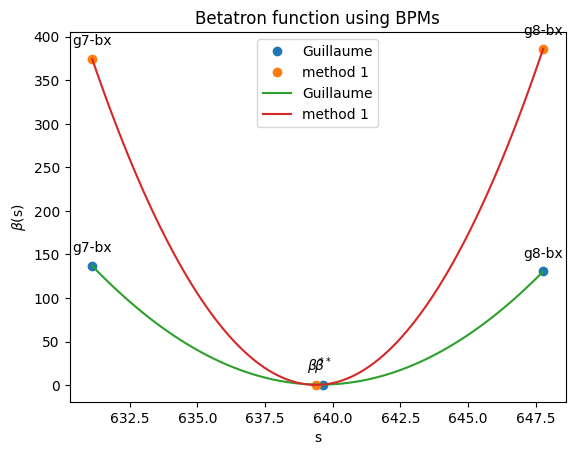

In [122]:
b1_g = 11.7**2

ss_g = .19918869 + sIP8
bs_g = .55506391

b2_g = 11.42**2

A_g, B_g, C_g = calc_parabola_vertex(s_g7_bx, b1_g, ss_g, bs_g, s_g8_bx, b2_g)
A_shift_g, B_shift_g, C_shift_g = calc_parabola_vertex(s_g7_bx - ss_g, b1_g, 0, bs_g, s_g8_bx - ss_g, b2_g)
print()
print("After shift:")
display(Math(r"Guillaume: %fx^2 + %dx + %f"%(A_shift_g, B_shift_g, C_shift_g)))

beta_BPM27, beta_BPM28 = (BPMx_Jbeta_Map[27]/Jconst_avg_weighted), (BPMx_Jbeta_Map[28]/Jconst_avg_weighted)
A, B, C = calc_parabola_vertex(s_g7_bx, beta_BPM27, sstar_avg_weighted, Bstar_avg_weighted, s_g8_bx, beta_BPM28)
A_shift, B_shift, C_shift = calc_parabola_vertex(s_g7_bx - sstar_avg_weighted, beta_BPM27, 0, Bstar_avg_weighted, s_g8_bx - sstar_avg_weighted, beta_BPM28)
display(Math(r"Method 1: %fx^2 + %dx + %f"%(A_shift, B_shift, C_shift)))

s_space = np.linspace(s_g7_bx, s_g8_bx, 100)
Betatron_g = A_g*s_space**2 + B_g*s_space + C_g
Betatron = A*s_space**2 + B*s_space + C
s_points_g = [s_g7_bx, ss_g, s_g8_bx]
b_points_g = [b1_g, bs_g, b2_g]

s_points_w = np.copy(s_points_g)
s_points_w[1] = s_star
b_points_w = [beta_BPM27, Bstar_avg_weighted, beta_BPM28]

plt.plot(s_points_g, b_points_g, 'o', label = "Guillaume")
plt.plot(s_points_w, b_points_w, 'o', label = "method 1")
for x, y, text in zip(s_points_g, b_points_g, 
                      [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
for x, y, text in zip(s_points_w, b_points_w, 
                      [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.plot(s_space, Betatron_g, label = "Guillaume")
plt.plot(s_space, Betatron, label = "method 1")
plt.title("Betatron function using BPMs")
plt.xlabel("s")
plt.ylabel(r"$\beta$(s)")
plt.legend()
plt.show()

Using Method 1 on Guillaume's beta values and comparing that to his original values:\
This means that my method works!! I just have the wrong constant value, in which I find using method 3 and show the fit above.


After shift:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

639.5462699382023 0.5208194083038068
0.1012419885843201


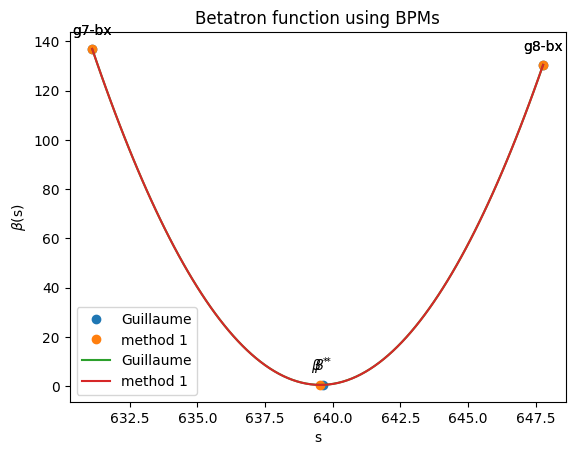

In [115]:
b1_g = 11.7**2

ss_g = .19918869 + sIP8
bs_g = .55506391

b2_g = 11.42**2

A_g, B_g, C_g = calc_parabola_vertex(s_g7_bx, b1_g, ss_g, bs_g, s_g8_bx, b2_g)
A_shift_g, B_shift_g, C_shift_g = calc_parabola_vertex(s_g7_bx - ss_g, b1_g, 0, bs_g, s_g8_bx - ss_g, b2_g)
print()
print("After shift:")
display(Math(r"Guillaume: %fx^2 + %dx + %f"%(A_shift_g, B_shift_g, C_shift_g)))

s_space = np.linspace(s_g7_bx, s_g8_bx, 100)
Betatron_g = A_g*s_space**2 + B_g*s_space + C_g
s_points_g = [s_g7_bx, ss_g, s_g8_bx]
b_points_g = [b1_g, bs_g, b2_g]

a_27_m1 = b1_g/L27_28 + np.sqrt((b1_g*b2_g/L27_28**2 - 1))
ss_m1 = s_g7_bx + a_27_m1*b1_g/(a_27_m1**2 + 1)
bs_m1 = (ss_m1 - s_g7_bx)/a_27_m1 #b1_g/(a_27_m1**2 + 1)
s_points_m1 = np.copy(s_points_g)
s_points_m1[1] = ss_m1
b_points_m1 = np.copy(b_points_g)
b_points_m1[1] = bs_m1

A_m1, B_m1, C_m1 = calc_parabola_vertex(s_g7_bx, b1_g, ss_m1, bs_m1, s_g8_bx, b2_g)
A_shift_m1, B_shift_m1, C_shift_m1 = calc_parabola_vertex(s_g7_bx - ss_m1, b1_g, 0, bs_m1, s_g8_bx - ss_m1, b2_g)
display(Math(r"Method 1: %fx^2 + %dx + %f"%(A_shift_m1, B_shift_m1, C_shift_m1)))
Betatron_m1 = A_m1*s_space**2 + B_m1*s_space + C_m1
print(ss_m1, bs_m1)
print(ss_m1 - sIP8)

plt.plot(s_points_g, b_points_g, 'o', label = "Guillaume")
plt.plot(s_points_m1, b_points_m1, 'o', label = "method 1")
for x, y, text in zip(s_points_g, b_points_g, 
                      [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
for x, y, text in zip(s_points_m1, b_points_m1, 
                      [Name_xbpms[27], r"$\beta^*$", Name_xbpms[28]]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.plot(s_space, Betatron_g, label = "Guillaume")
plt.plot(s_space, Betatron_m1, label = "method 1")
plt.title("Betatron function using BPMs")
plt.xlabel("s")
plt.ylabel(r"$\beta$(s)")
plt.legend()
plt.show()

## Guillaume star method

In [181]:
s_MADx = []
Betax_MADx = []
with open('twiss.out_Au23-100GeV-e0-beta5') as output:
    Lines = output.readlines()
    for i, line in enumerate(Lines[48:]):
        Line = re.split("\s+", line)
        Line[1] = Line[1].replace('_', '-')[1:-1]
        if Line[1] in np.char.upper(Name_xbpms) or Line[1] == 'BI9-B3.1': # because it is BI9-BH3.1 in the measurement file
            s_MADx.append(float(Line[2]))
            Betax_MADx.append(float(Line[3]))

s_MADx = np.array(s_MADx)
Betax_MADx = np.array(Betax_MADx)
# print(s_MADx)
# print(Betax_MADx[:20])

In [182]:
#print(Name_xbpms)
BetaArc = []
AmpArc = []
sArc = []
for i, name in enumerate(Name_xbpms):
    if name[0] != 'g' and name[-4:-2] == "bh" and int(name[-2:]) >= 10:
        #print(name)
        BetaArc.append(Betax_MADx[i])
        AmpArc.append(BPMx_Jbeta_Map[i])
        sArc.append(s_MADx[i])

        
BetaArc = np.array(BetaArc)
AmpArc = np.array(AmpArc)
J_g = (sum(AmpArc)/sum(BetaArc))
print(J_g)

0.005284123621289256


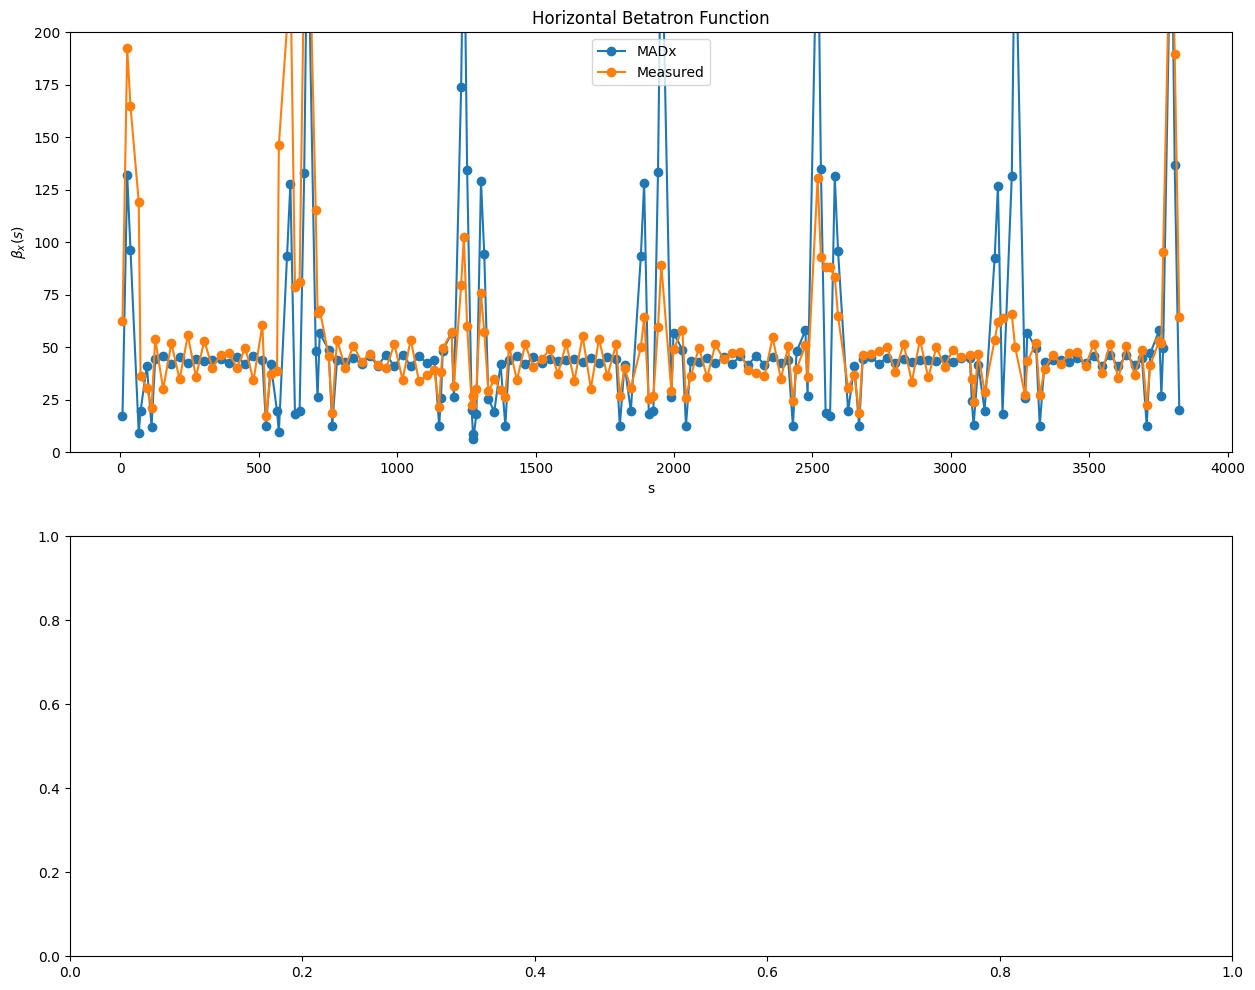

In [183]:
# Plot Betatron function and compare to actual betatron function
fig, Ax = plt.subplots(2, 1, figsize = (15, 12))
BPMx_betatron_Map = (BPMx_Jbeta_Map/J_g)

Ax[0].plot(s_MADx, Betax_MADx, "-o", label = "MADx")
Ax[0].plot(S_xbpms[0], BPMx_betatron_Map, '-o', label = "Measured")

Ax[0].set_xlabel("s")
Ax[0].set_ylabel(r"$\beta_x(s)$")
Ax[0].set_ylim([0, 200])
Ax[0].set_title(r"Horizontal Betatron Function")
Ax[0].legend()
plt.show()

In [184]:
def fit_beta(x, b1, s1):
    return b1 + ((x-s1)**2)/b1

tB = S_xbpms[0, 27:29] - sIP8
xB = BPMx_betatron_Map[27:29]
pB = np.array([.7, 0])
paramsB, _ = optimize.curve_fit(fit_beta, tB, xB, p0=pB)
display(Math(r"\beta^* = %f \newline \Delta s^* = %f"%(paramsB[0], paramsB[1])))

/Users/GrandmasterFung/env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Math object>

In [ ]:
# x0 = 3.07
# x0p = -.062465
# xc = 2.92
# beta = 1
# alpha = 0
# tunex = .235

# eps_nl = 1.6e-4
# eps_sr = .0034

xisige = 7.3e-4
nvs = 7.26e-4
phis = 4.16e-1

x0 = 2.73
x0p = -2.68e-1
xc = 2.93
beta = 1
alpha = 0
tunex = .2354

eps_nl = 1.96e-3
eps_sr = 6.27e-4

turns = np.arange(N_turns)
phi = 2*np.pi*tunex

cs = np.cos(turns*phi)
sn = np.sin(turns*phi)
m11 = cs + alpha*sn
m12 = beta*sn

alpha = 2*xisige*np.sin(np.pi*nvs*turns + phis)/nvs
alpha02 = (2*xisige*np.sin(phis)/nvs)**2
decay = np.exp(-(alpha**2 - alpha02)/2 - (eps_nl*turns)**2 - eps_sr*turns)
#decay = np.exp(-(eps_nl*turns)**2 - eps_sr*turns)
decay = np.exp(-(alpha**2 - alpha02)/2 - (eps_nl*turns)**2 - eps_sr*turns)
x_model = (m11*(x0 - xc) + m12*x0p)*decay + xc
diff = BPMx0 - x_model[initial: N_turns//2 + initial] + xc
interval = 100

plt.plot(turns[initial: interval + initial], BPMx0[initial: interval + initial], label = "data")
plt.plot(turns[initial: interval + initial], x_model[initial: interval + initial], label = "model", alpha = .75)
plt.plot(turns[initial: interval + initial], diff[initial: interval + initial], label = "difference", alpha = .5)
plt.legend()
plt.show()

In [ ]:
# a: amplitude
# b: decay
# c: tune
# d: phase
# e: shift
# f: mean
def model2(a, b, c, d, e, f, N_turns):
    
    x = np.arange(N_turns)
    #return a*np.exp(-2*((np.pi*(x + e))**2)/b**2)*np.cos(2*np.pi*c*(x + e) + d) + f
    return a*np.exp(-2*(np.pi*(x + e))/b**2)*np.cos(2*np.pi*c*(x + e) + d) + f

def log_likelihood2(theta, sigma, data):
    
    predicted_data = model2(*theta, len(data)) 
    diff = predicted_data - data
    ss = sigma[0]*sigma[0] + sigma[1]*sigma[1]*data*data
    
    return -np.sum(diff*diff/2.0/ss) - np.sum(np.log(np.sqrt(ss)))#*len(diff)

def metropolis_hastings2(lf, data, iters, pinitials, p_step,
                        sinitials=[1e-4,1e-4], s_step=[1e-4,1e-4]):
    psamples = np.zeros((iters, len(pinitials)))
    ssamples = np.zeros((iters, 2))
    p = np.array(pinitials)
    s = np.array(sinitials)
    pstep = np.array(p_step)
    sstep = np.array(s_step)
    changed = False
    old_lh = lf(p,s, data)
    i = 0
    while i<iters:
        p_n = p + np.random.normal(size=len(pinitials))*pstep
        s_n = s + np.random.normal(size=len(sinitials))*sstep
        if s_n[0] < 0: # error rms size >0
            continue
        if s_n[1] < 0: # error rms size >0
            continue
        if changed:
            #old_lh=lf(p,s, data)
            old_lh = new_lh
            
        new_lh = lf(p_n,s_n, data)
        if np.log(np.random.rand()+1.0e-10) < new_lh - old_lh:
            p,s = p_n,s_n
            changed = True
        else:
            changed = False
        psamples[i] = p
        ssamples[i] = s
        i += 1
    return psamples, ssamples

In [ ]:
#pinitials = [1, 30, tunex, np.pi, 1, BPMx0_mean]
#p_step = [1e-4, 1e-1, 1e-6, 1e-3, 1e-3, 5e-3]
pinitials = [.35, 30, tunex, -np.pi + 2.3, -5, BPMx0_mean]
p_step = [1e-3, 1e-1, 5e-7, 1e-3, 1e-2, 1e-3]
sinitials = [1e-2, 0e-2]
s_step = [2e-4, 0e-3]
N_iter = 100000

# parr : iters x 6; sarr = iters x 2
initial = 0
begin = time.time()
parr_red2, sarr_red2 = metropolis_hastings2(log_likelihood2, BPMx0[initial: N_turns//2 + initial], N_iter, 
                                         pinitials, p_step, sinitials, s_step)
end = time.time()
print("Time elapsed for reduced model:", end - begin)

In [ ]:
nrow = 3
ncol = 2
fig, Ax = plt.subplots(nrow, ncol, figsize=(20, 15))
fig.suptitle('Reduced Model')
Theta_names = ["Amplitude", "Decay", r"$\nu_x$", r"$\phi$", "shift", r"$x_c$"]
x_iter = np.linspace(0, N_iter//1000, N_iter)
split = N_iter//2 
Center2 = []
Stddev2 = []

for i in range(nrow):
    for j in range(ncol):
#         if i*ncol + j >= len(Theta_names):
#             break
        target = parr_red2.T[i*ncol + j]
        Ax[i][j].set_xlabel("Thousand Iterations")
        Ax[i][j].set_ylabel(Theta_names[i*ncol + j])
        Ax[i][j].plot(x_iter, target)
        center, stddev = np.average(target[split:]), np.std(target[split:])
        Center2.append(center)
        Stddev2.append(stddev)

plt.show()

In [ ]:
Center2 = np.array(Center2)
Stddev2 = np.array(Stddev2)
print(Center2)

x_model2 = model2(*Center2, N_turns)

# turns = np.arange(N_turns)
# a = .35
# b = 35
# c = tunex
# d = -np.pi + 2.3
# e = -5
# f = BPMx0_mean
# #x_model2 = a*np.exp(-2*((np.pi*(turns + e))**2)/b**2)*np.cos(2*np.pi*c*(turns + e) + d) + f
# x_model2 = a*np.exp(-2*(np.pi*(turns + e))/b**2)*np.cos(2*np.pi*c*(turns + e) + d) + f
diff2 = BPMx0 - x_model2 + BPMx0_mean
interval = 500

plt.plot(turns[initial: N_turns//2 + initial], BPMx0[initial: N_turns//2 + initial], label = "data")
plt.plot(turns[initial: N_turns//2 + initial], x_model2[initial: N_turns//2 + initial], label = "model", alpha = .75)
plt.plot(turns[initial: N_turns//2 + initial], diff2[initial: N_turns//2 + initial], label = "difference", alpha = .5)
plt.legend()
plt.show()

In [ ]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))
as_si(1.680304e-8,3)

plt.style.use('seaborn-white')

fig,(ax1,ax2)=plt.subplots(1,2, sharey=True,gridspec_kw = {'width_ratios':[5, 1]}, figsize=(4,2.5))
plt.subplots_adjust(wspace=0.0)
ax2.tick_params(axis='y', direction='in')
label=r"$\delta_{\xi}$"
label=r"$\nu_s$"
ax1.set_xlabel('Thousand Iterations')
ax1.set_ylabel(label)#r' [$\mu$m]')

target=sarr[:,0]*1000
target=parr[:,5]
iters=np.arange(0,len(target))
llen=len(target)*1//2
nbin=7
center,stddev=np.average(target[llen:]), np.std(target[llen:])
print(center,stddev)
ax1.set_xlim([0,len(target)/1000])
ax1.axvspan(llen/1000, len(target)/1000, alpha=0.1,color='c')
ax1.axvline(llen/1000, color='c', alpha=0.1)
#ax1.plot(iters/1000,target, label=label+r'={:.3f}'.format(center)+r'$\pm{0:s}$'.format(as_si(stddev,0))+r' $\mu$m')
#ax1.plot(iters/1000,target, label=label+r'={:.3f}$\pm${:.1f}'.format(center, stddev)+r' $\mu$m')
ax1.plot(iters/1000,target, label=label+r'=${0:s}$'.format(as_si(center,2))+r'$\pm{0:s}$'.format(as_si(stddev,0)))#r' $\mu$m')
tick2labels = ax2.get_xticklabels()
hist_data,_,_=ax2.hist(target[llen:], orientation='horizontal',density=True, color='c',bins=nbin)
ax2.set_xlim([0,np.max(hist_data)*1.1])
tick2labels[0]=''
ax2.set_xticklabels(tick2labels)
ax1.legend(loc='best')
fig.tight_layout()

plt.subplots_adjust(wspace=0.0)
#ax1.set_ylim([center-25*stddev, center+25*stddev])
#fig.savefig('synchrotron_tune.pdf', transparent=True, dpi=600)

In [ ]:
turns=np.arange(N_turns)
x0 = 3.07
x0p = -.062465
xc = 2.92
beta = 1
alpha = 0
tunex = .235
xisige = .00256
nvs = .0073
phis = 1.79
nstart_nl = 0
eps_nl = 1.6e-4
eps_sr = .0034

alpha=2*xisige*np.sin(np.pi*nvs*turns+phis)/nvs
alpha02=(2*xisige*np.sin(phis)/nvs)**2
A_model = np.exp(-(alpha*alpha-alpha02)/2.0-eps_nl*eps_nl*((turns+nstart_nl)**2-nstart_nl**2)-eps_sr*turns)
x_model = model(x0,x0p,xc,beta,alpha,tunex,eps_sr, eps_nl, nstart_nl, xisige,nvs,phis, Nturn=N_turns)

plt.plot(x, BPMx0, label = "data")
plt.plot(turns, x_model, label = "model")
plt.legend()
plt.show()